In [2]:
# 모델 관련 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler 
from sklearn.preprocessing import MinMaxScaler

# Data 관련 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

date: 경기 날짜를 나타냅니다. 경기가 언제 이루어졌는지를 추적할 수 있습니다.
game_size: 경기에서 참여한 총 플레이어 수를 나타냅니다. PUBG에서는 매치마다 플레이어 수가 달라질 수 있기 때문에 게임 크기가 중요할 수 있습니다.
match_id: 경기의 고유 식별자입니다. 개별 경기를 구분하는 데 사용되며, 예측 모델에서는 불필요한 정보로 제거될 수 있습니다.
match_mode: 게임 모드를 나타냅니다. 솔로, 듀오, 스쿼드 등 다양한 모드가 있으며, 각각의 모드는 플레이 스타일과 전략에 차이를 주기 때문에 예측에 영향을 줄 수 있습니다. 하지만 값이 하나뿐이라면 제거하는 것이 좋습니다.
party_size: 파티의 크기(플레이어 수)를 나타냅니다. 솔로, 듀오, 스쿼드와 같이 팀 구성을 나타내며, 순위에 영향을 미칠 수 있습니다.
player_assists: 플레이어가 도움을 준 횟수를 나타냅니다. 팀원에게 지원하여 적을 처치하는 등의 활동이 포함됩니다.
player_dbno: "Down But Not Out" 상태에 빠진 적의 수를 나타냅니다. 즉, 플레이어가 적을 쓰러뜨리지만, 완전히 처치하지는 않은 경우를 의미합니다.
player_dist_ride: 플레이어가 차량을 타고 이동한 거리입니다. 차량을 사용한 이동 전략을 나타낼 수 있습니다.
player_dist_walk: 플레이어가 걸어서 이동한 거리입니다. 도보로 이동한 거리 역시 플레이어의 생존 및 게임 전략을 반영할 수 있습니다.
player_dmg: 플레이어가 가한 총 대미지(데미지)를 나타냅니다. 플레이어가 전투에서 얼마나 공격적인지를 나타내는 중요한 지표입니다.
player_kills: 플레이어가 처치한 적의 수를 나타냅니다. 이는 플레이어의 성과를 직접적으로 반영하는 주요 지표 중 하나입니다.
player_name: 플레이어의 이름(닉네임)입니다. 식별 목적으로 사용되며, 모델 학습에는 불필요하므로 제거할 수 있습니다.
player_survive_time: 플레이어가 경기에서 생존한 시간(초)을 나타냅니다. 생존 시간은 순위에 매우 중요한 영향을 줄 수 있는 피처입니다.
team_id: 팀의 고유 식별자입니다. 팀을 구분하는 데 사용되지만 예측에 직접적으로 영향을 미치지 않으므로 제거하는 것이 좋습니다.
team_placement: 해당 팀의 최종 순위를 나타냅니다. 이 값이 타겟 레이블이 될 수 있으며, 순위 예측 모델의 목표가 됩니다

In [3]:
# 데이터 로딩
FILE_PATH = r"C:\Users\KDP15\Desktop\battlegroud\agg_match_stats_1.csv"

# CSV => DataFrame
df = pd.read_csv(FILE_PATH)

# 데이터 확인
df.head(3)

,date,game_size,match_id,match_mode,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_name,player_survive_time,team_id,team_placement
0,2017-11-26T01:47:01+0000,97,2U4GBNA0Yml_MDIpsXDjMltu0-r8UqS8skCECcelwiP7iu...,tpp,1,0,0,0.0,2082.823000,0,0,fuckeddup,661.491,100001,50
1,2017-11-26T01:47:01+0000,97,2U4GBNA0Yml_MDIpsXDjMltu0-r8UqS8skCECcelwiP7iu...,tpp,1,0,0,0.0,1118.815000,0,0,nojiongegg,741.359,100002,47
2,2017-11-26T01:47:01+0000,97,2U4GBNA0Yml_MDIpsXDjMltu0-r8UqS8skCECcelwiP7iu...,tpp,1,0,0,0.0,25.533026,73,0,Darthmoca,83.255,100006,97


In [4]:
df['party_size'].value_counts()

party_size
4    6517723
2    4447348
1    2879204
Name: count, dtype: int64

In [5]:
df['player_dist_ride'].value_counts()

player_dist_ride
0.000000       8036651
0.880000           399
0.880000           202
0.880000           130
0.880000           113
                ...   
1755.206670          1
2227.752440          1
10.951827            1
1392.211300          1
42.916380            1
Name: count, Length: 5266678, dtype: int64

In [6]:
df['game_size']

0           97
1           97
2           97
3           97
4           97
            ..
13844270    28
13844271    28
13844272    28
13844273    28
13844274    28
Name: game_size, Length: 13844275, dtype: int64

In [7]:
df['player_dbno'].value_counts()

player_dbno
0     9161909
1     2827692
2     1079431
3      424097
4      176676
5       80606
6       39259
7       20862
8       11897
9        7110
10       4510
11       2996
12       2047
13       1400
14        980
15        737
16        506
17        363
18        289
19        184
20        163
21        114
22         92
23         74
24         55
26         43
25         37
27         31
28         19
29         19
30         13
31         12
34         11
32         11
33          8
35          4
38          3
39          3
40          3
37          3
36          2
41          2
42          1
50          1
Name: count, dtype: int64

In [8]:
df.drop(columns=['date','match_id','match_mode','team_id'],inplace=True)

In [9]:
df.drop(columns='player_name',inplace=True)

In [10]:
df['party_size'].value_counts()

party_size
4    6517723
2    4447348
1    2879204
Name: count, dtype: int64

# 듀오모드만 사용

In [11]:
duoDF = df[df['party_size']==2]

In [12]:
# 노이즈가 생길수도있으니 game_size는 47이상으로만 제한
duoDF = duoDF[(duoDF['game_size']>=47) & (duoDF['team_placement']<=50)]

In [13]:
duoDF.isna().sum()

game_size              0
party_size             0
player_assists         0
player_dbno            0
player_dist_ride       0
player_dist_walk       0
player_dmg             0
player_kills           0
player_survive_time    0
team_placement         0
dtype: int64

In [14]:
bins = [1, 5, 25, 50]
labels = [0, 1, 2]  # 구간에 맞는 레이블 수

duoDF['placement'] = pd.cut(duoDF['team_placement'], bins=bins, labels=labels, right=True, include_lowest=True)


In [15]:
duoDF['placement']=duoDF['placement'].astype('int64')

In [16]:
duoDF.corr()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_placement,placement
game_size,1.000000,NaN,0.001095,-0.000246,0.007961,-0.001466,0.000484,0.001544,-0.001437,0.034055,0.017402
party_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player_assists,0.001095,NaN,1.000000,0.220876,0.176021,0.072430,0.361727,0.269584,0.317310,-0.297669,-0.305173
player_dbno,-0.000246,NaN,0.220876,1.000000,0.163796,0.081471,0.838193,0.822639,0.337947,-0.312664,-0.306545
player_dist_ride,0.007961,NaN,0.176021,0.163796,1.000000,0.265156,0.233378,0.207785,0.582644,-0.538281,-0.512839
player_dist_walk,-0.001466,NaN,0.072430,0.081471,0.265156,1.000000,0.109270,0.104233,0.231522,-0.213557,-0.199166
player_dmg,0.000484,NaN,0.361727,0.838193,0.233378,0.109270,1.000000,0.903735,0.461925,-0.426120,-0.424047
player_kills,0.001544,NaN,0.269584,0.822639,0.207785,0.104233,0.903735,1.000000,0.433915,-0.399582,-0.401573
player_survive_time,-0.001437,NaN,0.317310,0.337947,0.582644,0.231522,0.461925,0.433915,1.000000,-0.891864,-0.844118
team_placement,0.034055,NaN,-0.297669,-0.312664,-0.538281,-0.213557,-0.426120,-0.399582,-0.891864,1.000000,0.891178


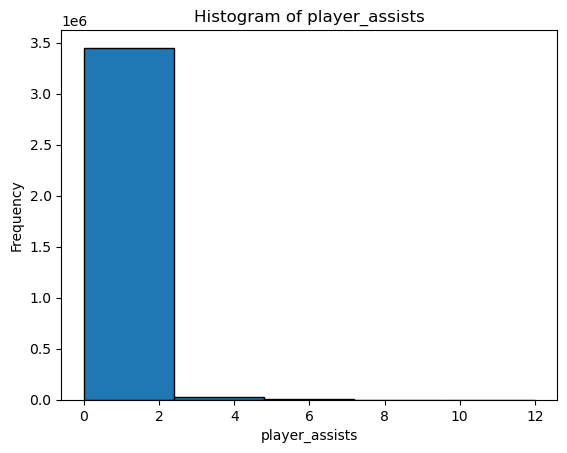

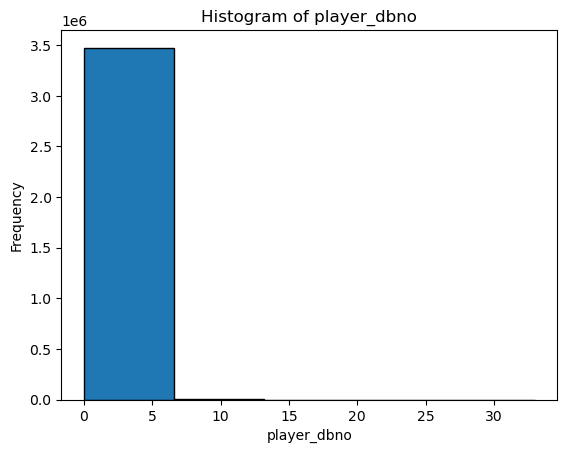

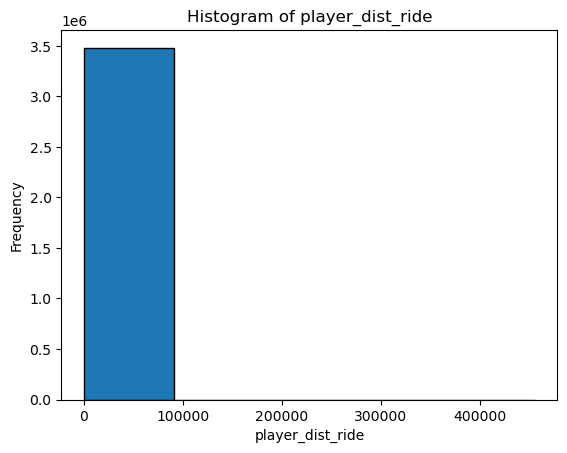

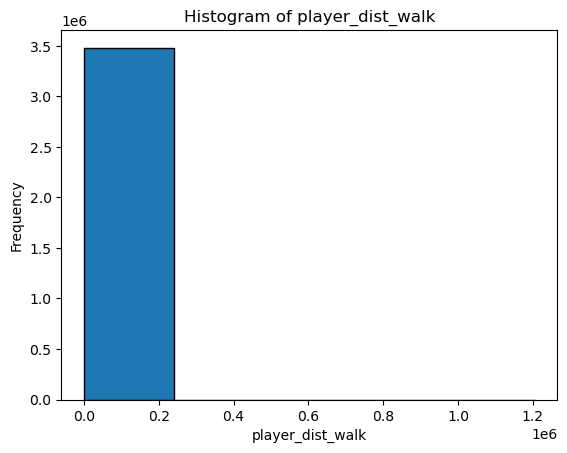

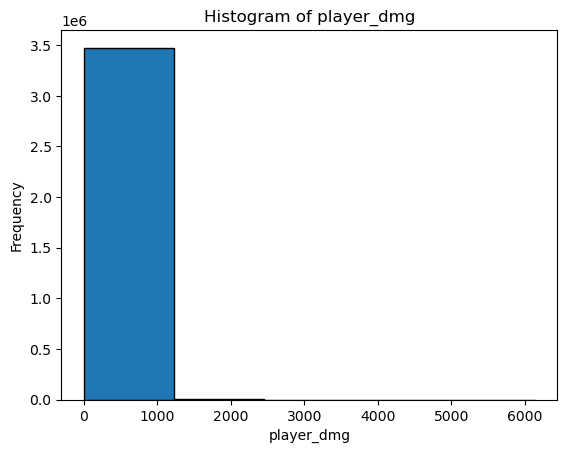

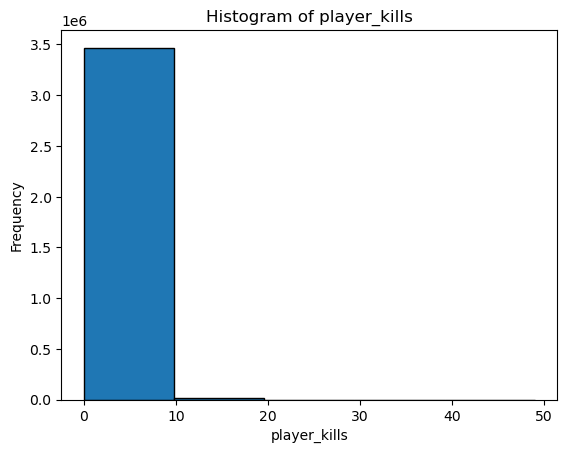

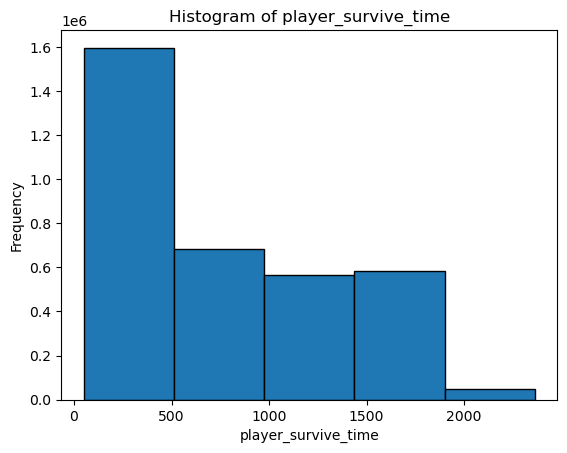

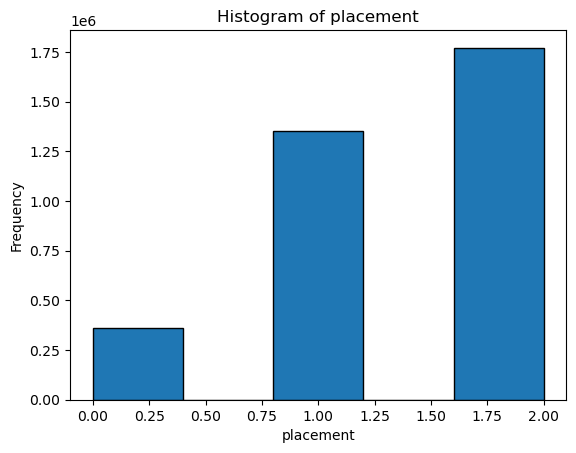

In [17]:
columns_to_plot = ['player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills', 'player_survive_time','placement']

# 각 컬럼에 대한 히스토그램을 개별적으로 그림
for col in columns_to_plot:
    plt.figure()
    plt.hist(duoDF[col], bins=5, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## 모델 생성

In [34]:
class MCFmodel(nn.Module):
    def __init__(self, in_in, out_out, h_list=[]):
        super().__init__()

        self.input_layer = nn.Linear(in_in,h_list[0])      #입력은 피쳐수
        self.bn_ipnut = nn.BatchNorm1d(h_list[0])
        
        self.h_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        for i in range(len(h_list)-1):
            self.h_layers.append(nn.Linear(h_list[i],h_list[i+1]))
            self.bn_layers.append(nn.BatchNorm1d(h_list[i+1]))
        
        self.out_layers = nn.Linear(h_list[-1], out_out)  # 타겟수
    
    def forward(self, x):
        y = F.relu(self.input_layer(x))  

        for i, h_layer in enumerate(self.h_layers):
            y=F.relu(self.bn_layers[i](h_layer(y)))   
        
        return self.out_layers(y) # 다중분류

In [19]:
class MAKEDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        # 넘파이를 텐서로
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [20]:
import joblib

In [35]:
# 피쳐, 타겟 추출
featureDF= duoDF[['player_assists','player_dbno', 'player_dist_walk', 'player_dmg', 'player_kills', 
'player_survive_time']]
targetDF = duoDF[['placement']]

print(f'featureDF => {featureDF.shape}, targetDF => {targetDF.shape}')


featureDF => (3481575, 6), targetDF => (3481575, 1)


In [36]:
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(featureDF)

scaled_featureDF = pd.DataFrame(scaled_features, columns=featureDF.columns)

In [38]:
# 학습 진행 관련 설정
EPOCH=30
BATCH_SIZE=32
BATCH_CNT=int(featureDF.shape[0]/BATCH_SIZE)
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
LR=0.0005

In [39]:
duoDF['placement'].value_counts()

placement
2    1771400
1    1350739
0     359436
Name: count, dtype: int64

In [40]:
X_train, X_val, y_train, y_val = train_test_split(scaled_featureDF, targetDF, random_state=32)
print(f'{X_train.shape} {X_val.shape}')
print(f'{y_train.shape} {y_val.shape}')

trainDS=MAKEDataset(X_train, y_train)
valDS=MAKEDataset(X_val, y_val)

(2611181, 6) (870394, 6)
(2611181, 1) (870394, 1)


In [41]:
model=MCFmodel(6,3,[32,16,8,4])

print(model)

MCFmodel(
  (input_layer): Linear(in_features=6, out_features=32, bias=True)
  (bn_ipnut): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (h_layers): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_layers): Linear(in_features=4, out_features=3, bias=True)
)


In [29]:
# 데이터로드 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

In [30]:
## 모델 파일 관련
### models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os

# 저장 경로
SAVE_PATH = '../models/pug/'
# 저장 파일명
#SAVE_FILE=SAVE_PATH+'model_train_wbs.pth'

# 모델 구조 및 파라미터 모두 저장 파일명명
SAVE_MODEL=SAVE_PATH+'model_all.pth'

In [31]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH) 

In [42]:
# 최적화 인스턴스 => W, b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)
# 최적화 스케쥴링 인스턴스 생성 ==> lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max' ,patience=5,verbose=True) #patience는 몇번까지 참을지 , 기본은 10

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss
#                            예측값은 선형식 결과값으로 전달 => AF 처리 X
weights = torch.tensor([2.043, 0.543, 0.414], dtype=torch.float32)

crossLoss=nn.CrossEntropyLoss(weight=)

c:\Users\KDP15\anaconda3\envs\TORCH_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTROY=[[],[]], [[],[]]

f1_score = MulticlassF1Score(num_classes=3, average='macro')
## 학습 모니터링/스케쥴링 설정
# => LOSS_HISTORY, SCORE_HISTORY 활용
# => 임계기준 : 10번

best_score = None

for epoch in range(1, EPOCH+1):
    # 학습 모드로 모델 설정
    model.train()
    #cnt=0
    # 배치크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0, 0
    f1_score.reset()
    
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산
        loss=crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()

        # 손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D, 타입은 long
        score=f1_score(pre_y, targetTS.reshape(-1))
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 추론/평가
        pre_val=model(val_featureTS)

        # 손실
        loss_val=crossLoss(pre_val, val_targetTS.reshape(-1).long())

        # 성능평가
        score_val=f1_score(pre_val, val_targetTS.reshape(-1))

    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/BATCH_CNT)
    SCORE_HISTROY[0].append(score_total/BATCH_CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTROY[1].append(score_val)

    # 최적화 스케쥴러 인스턴스 업데이트     , 검증을 봐야함
    scheduler.step(score_val)   
    
    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} [SCORE] : {SCORE_HISTROY[0][-1]}')
    print(f'- [VAL] LOSS : {LOSS_HISTORY[1][-1]} [SCORE] : {SCORE_HISTROY[1][-1]}')
    
    # 성능이 개선된 경우에만 모델 저장
    if best_score is None or score_val > best_score:
        best_score = score_val
        SAVE_MODEL = f'../models/pug/best_model_epoch_{epoch}'
        torch.save(model, SAVE_MODEL)
        print(f'Model {epoch} , best score: {best_score}')


[1/30]
- [TRAIN] LOSS : 0.26043296595316234 [SCORE] : 0.6301389166557804
- [VAL] LOSS : 0.3431558310985565 [SCORE] : 0.8536970615386963
Model 1 , best score: 0.8536970615386963
[2/30]
- [TRAIN] LOSS : 0.25053160057202645 [SCORE] : 0.6325719424650041
- [VAL] LOSS : 0.32955899834632874 [SCORE] : 0.8587743043899536
Model 2 , best score: 0.8587743043899536
[3/30]
- [TRAIN] LOSS : 0.24947528416964262 [SCORE] : 0.6331651974720233
- [VAL] LOSS : 0.3348429799079895 [SCORE] : 0.8560537695884705
[4/30]
- [TRAIN] LOSS : 0.248976442319205 [SCORE] : 0.6334515190543392
- [VAL] LOSS : 0.33139434456825256 [SCORE] : 0.8565276861190796
[5/30]
- [TRAIN] LOSS : 0.24858624318308306 [SCORE] : 0.6336897098008095
- [VAL] LOSS : 0.3299480378627777 [SCORE] : 0.8568316698074341
[6/30]
- [TRAIN] LOSS : 0.24833135109598414 [SCORE] : 0.6337998473652146
- [VAL] LOSS : 0.33007004857063293 [SCORE] : 0.8567013740539551
[7/30]
- [TRAIN] LOSS : 0.24807910140044673 [SCORE] : 0.6339843179890029
- [VAL] LOSS : 0.33107078075

KeyboardInterrupt: 

In [45]:
from function_list import plot_loss_score

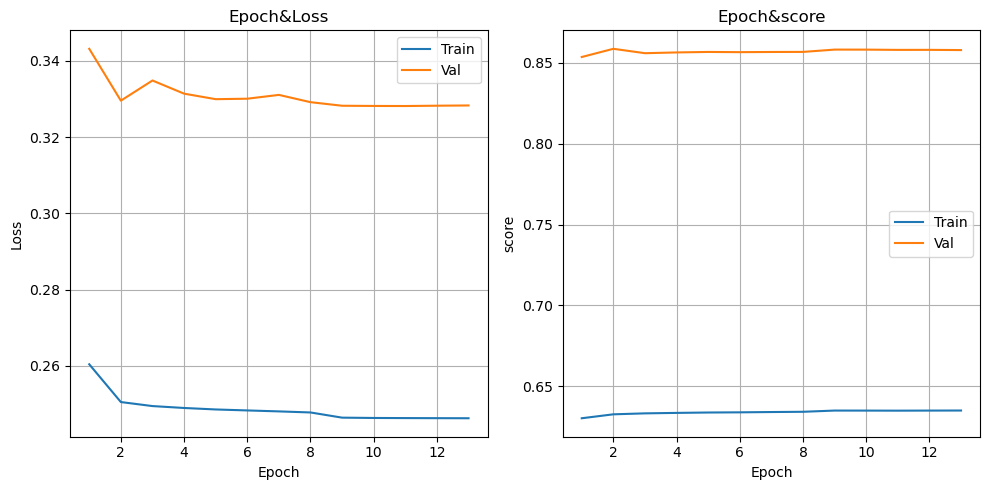

In [46]:
plot_loss_score(LOSS_HISTORY, SCORE_HISTROY, 'score')